In [1]:
# import necessary module
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import scipy
from array_response import *
import itertools 

from IPython.display import Image
from matplotlib.gridspec import GridSpec



### Parameters declaration

Declare parameters needed for channel realization

In [2]:
Ns = 1 # number of streams

Nc = 6 # number of cluster
Nray = 10 # number of rays in each cluster

Nt = 64 # number of transmit antennas
Nr = 16 # number of receive antennas

angle_sigma = 10/180*np.pi # standard deviation of the angles in azimuth and elevation both of Rx and Tx

gamma = np.sqrt((Nt*Nr)/(Nc*Nray))
realization = 1000 # equivalent to number of taking sample
count = 0

eps = 0.1 # 20dB isolation
sigma = np.sqrt(8/(1+eps**2)) # according to the normalization condition of H


### Channel Realization

Realize channel H for Dual-Polarized antenna array

In [3]:
H_pol = np.zeros((2*Nr,2*Nt,realization),dtype=complex)
At = np.zeros((Nt,Nc*Nray,realization),dtype=complex)
Ar = np.zeros((Nr,Nc*Nray,realization),dtype=complex)
alpha_hh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_hv = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vv = np.zeros((Nc*Nray,realization),dtype=complex)
Fopt = np.zeros((2*Nt,Ns,realization),dtype=complex)
Wopt = np.zeros((2*Nr,Ns,realization),dtype=complex)


AoD = np.zeros((2,Nc*Nray),dtype=complex)
AoA = np.zeros((2,Nc*Nray),dtype=complex)

H = np.zeros((2*Nr,2*Nt,realization),dtype=complex)
azi_rot = np.random.uniform(0,2*np.pi,realization)
ele_rot = np.random.uniform(0,np.pi/2,realization) # Why PI/2 ??
R = np.array([[np.cos(ele_rot)*np.cos(azi_rot),np.sin(ele_rot)],[-np.sin(ele_rot)*np.cos(azi_rot),np.cos(ele_rot)]]) # rotation matrix

for reali in range(realization):
    for c in range(1,Nc+1):
        AoD_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Departure _ azimuth
        AoD_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Departure _ elevation
        AoA_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Arrival_ azimuth
        AoA_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Arrival_ elevation
        AoD[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_azi_m, angle_sigma, (1,Nray))
        AoD[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_ele_m, angle_sigma, (1,Nray))
        AoA[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_azi_m, angle_sigma, (1,Nray))
        AoA[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_ele_m, angle_sigma, (1,Nray))
    for j in range(Nc*Nray):
        At[:,j,reali] = array_response(AoD[0,j],AoD[1,j],Nt)/np.sqrt(2) # UPA array response
        Ar[:,j,reali] = array_response(AoA[0,j],AoA[1,j],Nr)/np.sqrt(2)
        var_hh = ((sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_hv = ((eps**2)*(sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_vh = ((eps**2)*(sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[1,j])**2)).real
        var_vv = ((sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[1,j])**2)).real
        alpha_hh[j,reali] = np.random.normal(0, np.sqrt(var_hh/2)) + 1j*np.random.normal(0, np.sqrt(var_hh/2))
        alpha_hv[j,reali] = np.random.normal(0, np.sqrt(var_hv/2)) + 1j*np.random.normal(0, np.sqrt(var_hv/2))
        alpha_vh[j,reali] = np.random.normal(0, np.sqrt(var_vh/2)) + 1j*np.random.normal(0, np.sqrt(var_vh/2))
        alpha_vv[j,reali] = np.random.normal(0, np.sqrt(var_vv/2)) + 1j*np.random.normal(0, np.sqrt(var_vv/2))
        alpha = np.vstack((np.hstack((alpha_hh[j,reali],alpha_hv[j,reali])),np.hstack((alpha_vh[j,reali],alpha_vv[j,reali]))))
        H_pol[:,:,reali] = H_pol[:,:,reali] + np.kron(alpha,Ar[:,[j],reali]@At[:,[j],reali].conj().T)
    H_pol[:,:,reali] = 2*gamma* H_pol[:,:,reali]
    H[:,:,reali] = (np.kron(R[:,:,reali],np.eye(Nr)))@H_pol[:,:,reali]
    H[:,:,reali] = np.sqrt(4/3)* H[:,:,reali]
    
    if (np.linalg.matrix_rank(H[:,:,reali])>=Ns):
        U, s, V = np.linalg.svd(H[:,:,reali], full_matrices=True)
        V = V.conj().T
        Fopt[:,:,reali] = V[0:2*Nt,0:Ns]
        Wopt[:,:,reali] = U[0:2*Nr,0:Ns]

### Check normalized condition

In [4]:
channel_fro_1 = np.zeros(realization)
for reali in range(realization):
    channel_fro_1[reali] = np.linalg.norm(H_pol[:,:,reali],'fro')
print("4*Nt*Nr =", 4*Nt*Nr , "   Frobenius norm H pol=", np.mean(channel_fro_1**2))

4*Nt*Nr = 4096    Frobenius norm H pol= 4139.4746016294785


In [5]:
channel_fro_2 = np.zeros(realization)
for reali in range(realization):
    channel_fro_2[reali] = np.linalg.norm(H[:,:,reali],'fro')
print("4*Nt*Nr =", 4*Nt*Nr , "   Frobenius norm =", np.mean(channel_fro_2**2))

4*Nt*Nr = 4096    Frobenius norm = 4110.904496150216


### OMP

In [6]:
def OMP_dual(_Fopt,_NRF,_At):
    _FRF = np.empty((2*_At.shape[0],0))
    _Fres = _Fopt
#     Nt = int(Fopt.shape[0]/2)
    Nt = int(_At[:,:].shape[0])
    for k in range(_NRF):
        PU_h = _At.conj().T@_Fres[0:Nt,:]
        ind_h = np.argmax(np.sum((np.absolute(PU_h))**2,axis=1))
        PU_v = _At.conj().T@_Fres[Nt:2*Nt,:]
        ind_v = np.argmax(np.sum((np.absolute(PU_v))**2,axis=1))
        _FRF = np.append(_FRF,np.vstack((_At[:,[ind_h]],_At[:,[ind_v]])) ,axis=1)
        _FBB = (np.linalg.pinv(_FRF))@_Fopt
        _Fres = (_Fopt-_FRF@_FBB)/np.linalg.norm((_Fopt-_FRF@_FBB),'fro')
#         _Fres = (_Fopt-_FRF@_FBB)
    return _FRF,_FBB

In [7]:
int(At[:,:].shape[0])

64

### Plot Spectral Efficiency with Precoder and Combiner getting from OMP

In [8]:
NRF = 6
SNR_dB = np.arange(-35,10,5)
SNR = 10**(SNR_dB/10)
smax = SNR.shape[0]
R = np.zeros([smax, realization],dtype=complex)
R_o = np.zeros([smax, realization],dtype=complex)

for reali in range(realization):
    FRF, FBB = OMP_dual( Fopt[:,:,reali], NRF, At[:,:,reali])
    FBB = np.sqrt(Ns)*FBB/np.linalg.norm(FRF@FBB,'fro')
    WRF, WBB = OMP_dual( Wopt[:,:,reali], NRF, Ar[:,:,reali])
    WBB = np.sqrt(Ns)*WBB/np.linalg.norm(WRF@WBB,'fro')
    
    for s in range(smax):
        R[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+SNR[s]/Ns*np.linalg.pinv(WRF@WBB)@H[:,:,reali]@FRF@FBB@FBB.conj().T@FRF.conj().T@H[:,:,reali].conj().T@WRF@WBB))
        R_o[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+SNR[s]/Ns*np.linalg.pinv(Wopt[:,:,reali])@H[:,:,reali]@Fopt[:,:,reali]@Fopt[:,:,reali].conj().T@H[:,:,reali].conj().T@Wopt[:,:,reali]))


In [40]:
Fopt.shape

(128, 1, 1000)

In [41]:
x = np.linalg.norm(Fopt[:,:,0],'fro')
print("Ns", Ns , "   Frobenius norm FRF*FBB=", x**2)

Ns 1    Frobenius norm FRF*FBB= 0.9999999999999991


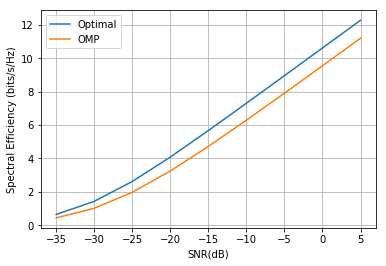

In [9]:
# plt.plot(SNR_dB, (np.sum(R,axis=1).real)/realization, label='OMP')
plt.plot(SNR_dB, (np.sum(R_o,axis=1).real)/realization, label='Optimal')
plt.plot(SNR_dB, (np.sum(R,axis=1).real)/realization, label='OMP')

plt.legend(loc='upper left')
plt.xlabel('SNR(dB)')
plt.ylabel('Spectral Efficiency (bits/s/Hz)')
plt.grid()
plt.show()

### Joint Horizontal/Vertical Beamformer Selection

| hori_tx | hori_rx | verti_tx | verti_rx |
|:--------|--------|--------:|:---------:|

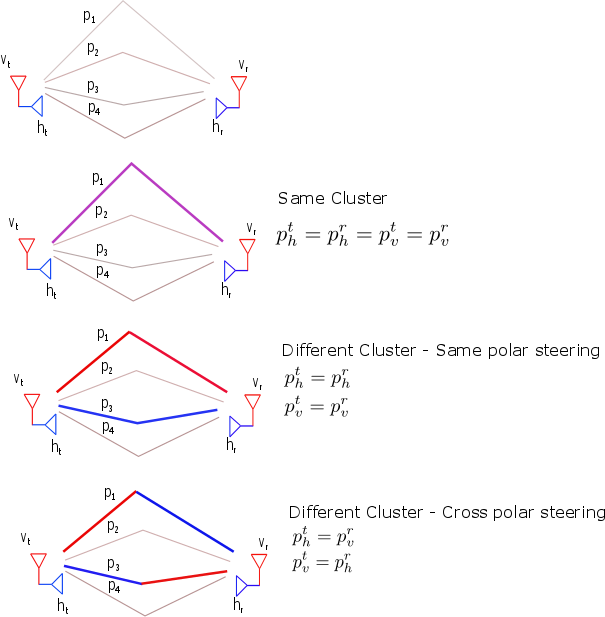

In [10]:
Image("img/cluster.png")

### Histogram of chosen path

__path gain of each combination__

Numpath = number of total combination

path_combi = arrangement of combination

In [11]:
total_combi = Nc*Nray
cluster = np.arange(total_combi)
print(cluster)
c = list(itertools.combinations(cluster, 2))
num_path = (2*total_combi-1)*total_combi
path_combi = np.zeros((num_path,4),dtype=int)

print(path_combi.shape)
path_combi[0:total_combi,:]=np.arange(total_combi).reshape(total_combi,1).repeat(4,axis=1)

count = 0
for i in range(int(total_combi*(total_combi-1)/2)):
    path_combi[total_combi+4*i,:] = np.array([c[count][0],c[count][0],c[count][1],c[count][1]])
    path_combi[total_combi+4*i+1,:] = np.array([c[count][1],c[count][1],c[count][0],c[count][0]])
    path_combi[total_combi+4*i+2,:] = np.array([c[count][0],c[count][1],c[count][1],c[count][0]])
    path_combi[total_combi+4*i+3,:] = np.array([c[count][1],c[count][0],c[count][0],c[count][1]])
    count = count+1
# print(path_combi[0:10,:])
path_gain = np.zeros((num_path,realization)) # 2 to save the position and maximum value
for reali in range(realization):
    for combi in range(num_path):
        path_gain[combi,reali] =\
        (np.abs\
         ((np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[path_combi[combi,0],reali]+np.sin(ele_rot[reali])*alpha_vh[path_combi[combi,0],reali])*(path_combi[combi,0]==path_combi[combi,1])+\
         (np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[path_combi[combi,2],reali]+np.sin(ele_rot[reali])*alpha_vv[path_combi[combi,2],reali])*(path_combi[combi,2]==path_combi[combi,1])+\
         (-np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[path_combi[combi,0],reali]+np.cos(ele_rot[reali])*alpha_vh[path_combi[combi,0],reali])*(path_combi[combi,0]==path_combi[combi,3])+\
         (-np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[path_combi[combi,2],reali]+np.cos(ele_rot[reali])*alpha_vv[path_combi[combi,2],reali])*(path_combi[combi,2]==path_combi[combi,3])
         ))**2


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
(7140, 4)


In [12]:
print(num_path)
print(path_gain.shape)
print(alpha_hh.shape)

7140
(7140, 1000)
(60, 1000)


__Check maximum gain from combination of path in each realization__

To do the joint polar beam steering later

In [13]:
index = np.zeros(realization,dtype=int)
for reali in range(realization):
    index[reali] = np.argmax(path_gain[:,reali])


__Create the Cross and Co Polar Index__

In [14]:
cross_index =  []
samepolar_index = []
count = total_combi-1
while (count<num_path-4):
    cross_index.extend([count+3,count+4])
    samepolar_index.extend([count+1,count+2])
    count = count + 4
cross_index = np.array(cross_index)
samepolar_index = np.array(samepolar_index)
sameclus_index = np.arange(0,total_combi)
print(cross_index)
print(samepolar_index)
print(sameclus_index)

[  62   63   66 ... 7135 7138 7139]
[  60   61   64 ... 7133 7136 7137]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]


In [15]:
cross_index_in = np.isin(index, cross_index)
samepolar_index_in = np.isin(index, samepolar_index)

sum_cross = sum(cross_index_in)
sum_co = sum(samepolar_index_in)
sum_sameclus = 1000 - sum(samepolar_index_in) - sum(cross_index_in)
print('Number of Cross Index chosen in 1000 realization: ',sum_cross)
print('Number of Same Polar Index chosen in 1000 realization: ',sum_co)
print('Number of Same Cluster Index chosen in 1000 realization: ',sum_sameclus)

Number of Cross Index chosen in 1000 realization:  243
Number of Same Polar Index chosen in 1000 realization:  297
Number of Same Cluster Index chosen in 1000 realization:  460


In [16]:
nu_path_sameclus = total_combi
nu_path_copolar = total_combi*(total_combi-1)
nu_path_crpolar = total_combi*(total_combi-1)
print(nu_path_sameclus)
print(nu_path_copolar)
print(nu_path_crpolar)
print(num_path)

60
3540
3540
7140


__Plot Distribution of Index Chosen__

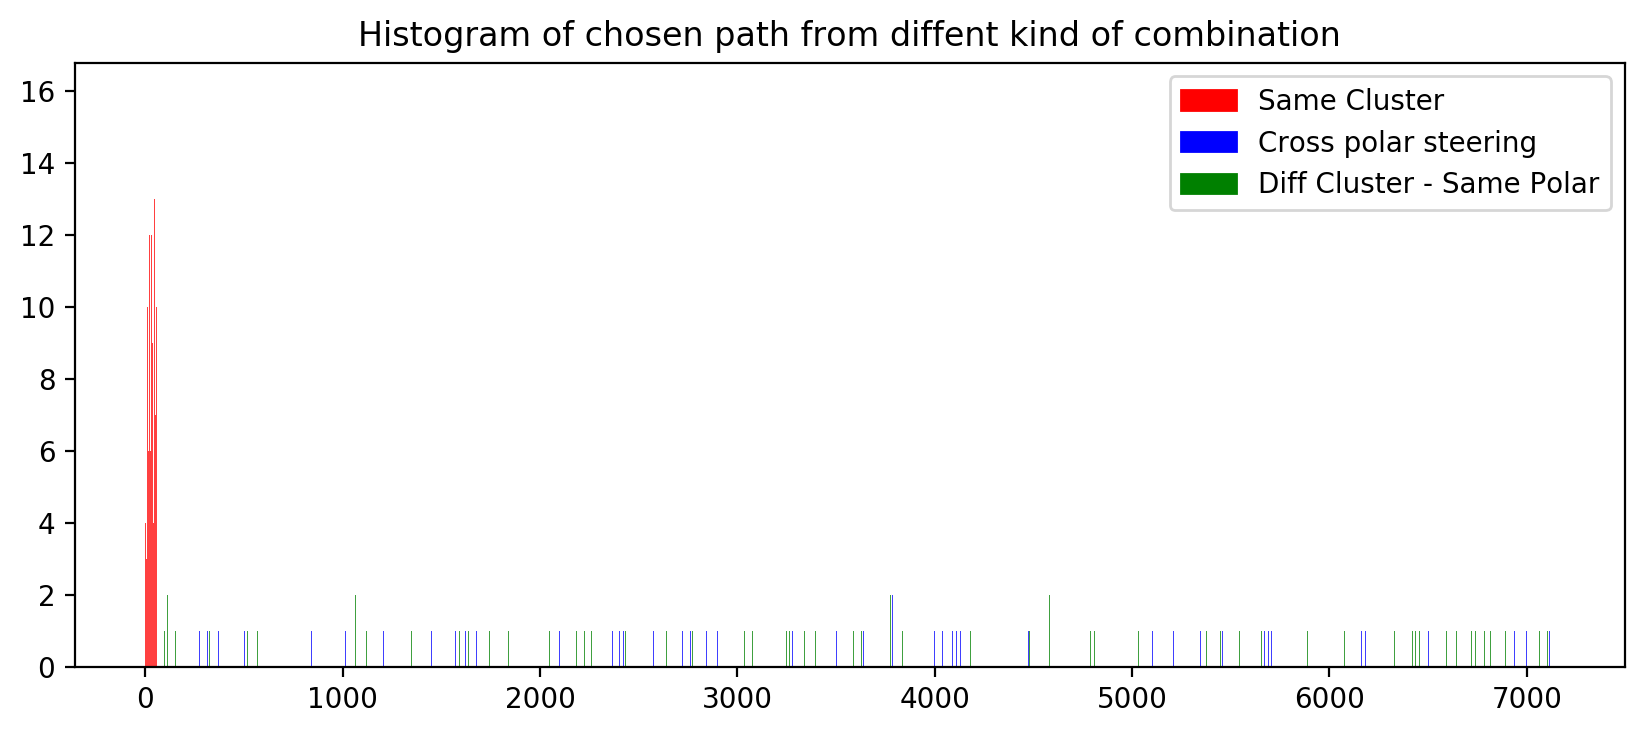

In [17]:
fig = plt.figure(figsize=(10,4), dpi=200)
n, bins, patches = plt.hist(index, bins=range(0,num_path+1),facecolor='green', alpha=0.75)
# ,edgecolor='black'
# print(n.shape)
# print(bins.shape)
# print(n)
# print(bins)

for i in range(0,total_combi):
    patches[i].set_fc('r')
for j in cross_index:
    patches[j].set_fc('b')
    
cluster_same = mpatches.Patch(color='red', label='Same Cluster')
cross_polar = mpatches.Patch(color='blue', label='Cross polar steering')
diff_clus_same_polar = mpatches.Patch(color='green', label='Diff Cluster - Same Polar')

plt.legend(handles=[cluster_same,cross_polar,diff_clus_same_polar])
plt.title('Histogram of chosen path from diffent kind of combination')
plt.show()


In [18]:
unique, counts = np.unique(index, return_counts=True)
print(dict(zip(unique, counts)))


{0: 10, 1: 4, 2: 6, 3: 7, 4: 8, 5: 4, 6: 3, 7: 8, 8: 9, 9: 13, 10: 6, 11: 10, 12: 7, 13: 8, 14: 4, 15: 7, 16: 6, 17: 13, 18: 16, 19: 10, 20: 11, 21: 12, 22: 5, 23: 5, 24: 10, 25: 2, 26: 6, 27: 4, 28: 5, 29: 4, 30: 10, 31: 12, 32: 10, 33: 6, 34: 5, 35: 8, 36: 9, 37: 7, 38: 5, 39: 11, 40: 10, 41: 4, 42: 5, 43: 4, 44: 5, 45: 6, 46: 13, 47: 6, 48: 8, 49: 7, 50: 6, 51: 7, 52: 5, 53: 8, 54: 10, 55: 10, 56: 10, 57: 10, 58: 6, 59: 14, 60: 1, 4106: 1, 4158: 1, 3135: 1, 4162: 1, 2048: 1, 5151: 1, 73: 1, 74: 1, 4060: 1, 4173: 1, 6227: 1, 4110: 1, 6230: 1, 6231: 1, 1112: 1, 5209: 1, 5210: 1, 2575: 1, 4189: 1, 1120: 1, 97: 1, 6895: 1, 2148: 2, 4099: 1, 4856: 1, 5137: 1, 1128: 1, 1129: 1, 6162: 1, 112: 2, 5233: 1, 2162: 2, 1043: 1, 4212: 1, 2165: 1, 1142: 1, 1145: 1, 123: 1, 2173: 1, 2175: 2, 3776: 2, 4226: 1, 1155: 1, 4228: 1, 5254: 1, 2185: 1, 139: 1, 4979: 1, 1173: 1, 1177: 1, 879: 1, 3098: 1, 4255: 1, 1184: 1, 1185: 1, 2211: 1, 3236: 1, 1189: 1, 2214: 1, 5288: 1, 5289: 1, 5290: 1, 4268: 1, 5293:

__PieChart__

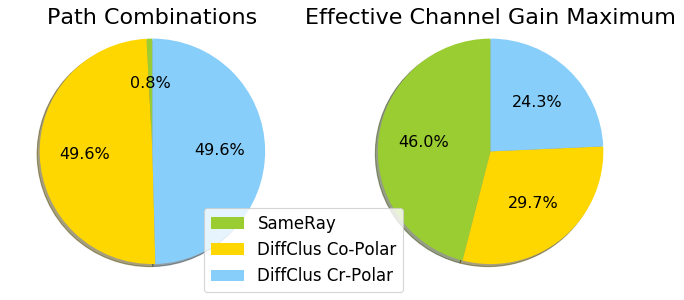

In [19]:
fig = plt.figure(figsize=(10,4), dpi=80)

the_grid = GridSpec(1, 2)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']

labels = 'SameRay', 'DiffClus Co-Polar', 'DiffClus Cr-Polar'
chosen_max = [sum_sameclus, sum_co, sum_cross]
num_in_totalpath = [nu_path_sameclus,nu_path_copolar,nu_path_crpolar]
explode = (0, 0, 0) 

plt.subplot(the_grid[0, 0], aspect=1)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

patches, texts,autotexts = plt.pie(num_in_totalpath, explode=explode,colors=colors,  autopct='%1.1f%%',shadow=True, startangle=90)
for t in texts:
    t.set_size('x-large')
for t in autotexts:
    t.set_size('x-large')
    
plt.title("Path Combinations",fontsize = 20)

plt.subplot(the_grid[0, 1], aspect=1)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
patches, texts,autotexts = plt.pie(chosen_max, explode=explode,colors=colors,  autopct='%1.1f%%',shadow=True, startangle=90)
for t in texts:
    t.set_size('x-large')
for t in autotexts:
    t.set_size('x-large')
plt.legend(patches,labels,bbox_to_anchor=[0.22, 0.3], loc="best",prop={'size': 15})
plt.title("Effective Channel Gain Maximum",fontsize=20)

plt.show()

### Distribution of each kind of combination by simulation

__Index of Same Cluster Max__

In [20]:
index_sameclus = np.zeros(realization,dtype=int)
for reali in range(realization):
    index_sameclus[reali] = np.argmax(path_gain[0:total_combi,reali])

In [21]:
gain_sameclus = np.zeros(realization,dtype=float)
for reali in range(realization):
    gain_sameclus[reali] = path_gain[index_sameclus[reali],reali]

__Index of Different Cluster-Cross Polar Max__

In [22]:
cross_index

array([  62,   63,   66, ..., 7135, 7138, 7139])

In [23]:
index_diffclus_crosspol = np.zeros(realization,dtype=int)
for reali in range(realization):
    index_diffclus_crosspol[reali] = np.argmax(path_gain[cross_index,reali])

In [24]:
gain_diffclus_crosspol = np.zeros(realization,dtype=float)
for reali in range(realization):
    gain_diffclus_crosspol[reali] = path_gain[cross_index[np.argmax(path_gain[cross_index,reali])],reali]

__Index of Different Cluster-Same Polar Max__

In [25]:
samepolar_index

array([  60,   61,   64, ..., 7133, 7136, 7137])

In [26]:
index_diffclus_samepol = np.zeros(realization,dtype=int)
for reali in range(realization):
    index_diffclus_samepol[reali] = np.argmax(path_gain[samepolar_index,reali])

In [27]:
gain_diffclus_samepol = np.zeros(realization,dtype=float)
for reali in range(realization):
    gain_diffclus_samepol[reali] = path_gain[samepolar_index[np.argmax(path_gain[samepolar_index,reali])],reali]

### Plot the Distribution

Average of Same Cluster Gain Distribution: 30.537979741273702
Average of Different Cluster - Cross polar Distribution: 19.470419951962718
Average of Different Cluster - Same polar Gain Distribution: 20.971377014858


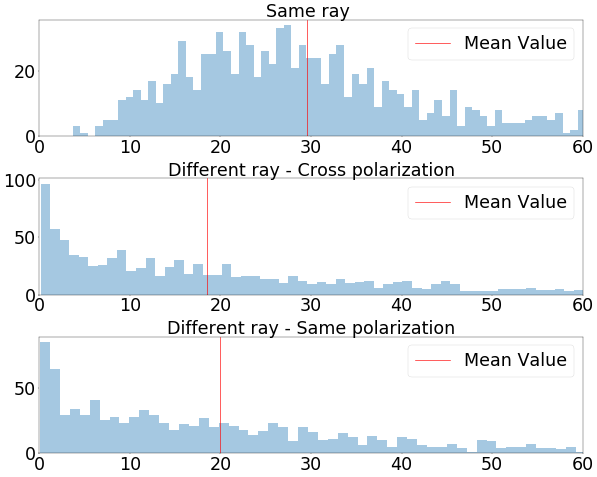

In [28]:
fig = plt.figure(figsize=(20,16), dpi=30)

plt.subplot(3, 1, 1)
plt.title('Same ray ', fontsize = 42)
sns.distplot(gain_sameclus,bins=150, kde = False)
plt.xlim(0,60)
plt.tick_params(axis='both', which='major', labelsize=42)

print('Average of Same Cluster Gain Distribution:',np.mean(gain_sameclus))
plt.axvline(np.mean(gain_sameclus)-1, color='r', linestyle='solid',label="Mean Value")
plt.legend(fontsize=42)


plt.subplot(3, 1, 2)
plt.title('Different ray - Cross polarization', fontsize = 42)
sns.distplot(gain_diffclus_crosspol,bins=100, kde = False)
plt.xlim(0,60)
plt.tick_params(axis='both', which='major', labelsize=42)
plt.axvline(np.mean(gain_diffclus_crosspol)-1, color='r', linestyle='solid',label="Mean Value")
plt.legend(fontsize=42)

print('Average of Different Cluster - Cross polar Distribution:',np.mean(gain_diffclus_crosspol))

plt.subplot(3, 1, 3)
plt.title('Different ray - Same polarization', fontsize = 42)
sns.distplot(gain_diffclus_samepol,bins=100, kde = False)
plt.xlim(0,60)
plt.tick_params(axis='both', which='major', labelsize=42)
plt.axvline(np.mean(gain_diffclus_samepol)-1, color='r', linestyle='solid',label="Mean Value")
plt.legend(fontsize=42)

plt.tight_layout()
print('Average of Different Cluster - Same polar Gain Distribution:',np.mean(gain_diffclus_samepol))

In [29]:
# fig = plt.figure(figsize=(20,20), dpi=50)

# plt.subplot(2, 1, 1)
# plt.title('Same Cluster - Different Cluster Cross polar', fontsize = 28)
# sns.distplot(gain_sameclus-gain_diffclus_crosspol,bins=180, kde = False)
# plt.xlim(-50,100)
# plt.tick_params(axis='both', which='major', labelsize=20)
# print('Average of Same Cluster Gain Distribution:',np.mean(gain_sameclus))

# plt.subplot(2, 1, 2)
# plt.title('Different Cluster - Cross polar Gain Distribution', fontsize = 28)
# sns.distplot(gain_sameclus-gain_diffclus_samepol,bins=100, kde = False)
# plt.xlim(-50,100)
# plt.tick_params(axis='both', which='major', labelsize=20)
# print('Average of Different Cluster - Cross polar Gain Distribution:',np.mean(gain_sameclus-gain_diffclus_crosspol))
# print(np.count_nonzero(gain_sameclus>gain_diffclus_crosspol)/1000)
# print(np.count_nonzero(gain_sameclus>gain_diffclus_samepol)/1000)
# print(np.count_nonzero(gain_sameclus>np.maximum(gain_diffclus_samepol,gain_diffclus_crosspol))/1000)

### Independent Beam Steering Horizontal | Vertical 

In [30]:
steer_path = np.zeros((2,realization),dtype=int)
for reali in range(realization):
    steer_path[0,reali] = np.argmax((np.abs(alpha_hh[:,reali]))**2)
    steer_path[1,reali] = np.argmax((np.abs(alpha_vv[:,reali]))**2)
    

### Plot Spectral Efficiency

In [31]:
SNR_dB = np.arange(-35,10,5)
SNR = 10**(SNR_dB/10)
smax = SNR.shape[0]
R_cross = np.zeros([smax, realization],dtype=complex)
R_steer = np.zeros([smax, realization],dtype=complex)
R_samecl = np.zeros([smax, realization],dtype=complex)


for reali in range(realization):
    _chosen_combi_path = path_combi[index[reali]]
    _chosen_steer_path = steer_path[:,reali]
    _chosen_sameclus_path = path_combi[index_sameclus[reali]]
    
    W_cross = np.vstack((Ar[:,[_chosen_combi_path[1]],reali],Ar[:,[_chosen_combi_path[3]],reali]))
    F_cross = np.vstack((At[:,[_chosen_combi_path[0]],reali],At[:,[_chosen_combi_path[2]],reali]))
    
    W_steer = np.vstack((Ar[:,[_chosen_steer_path[0]],reali],Ar[:,[_chosen_steer_path[1]],reali]))
    F_steer = np.vstack((At[:,[_chosen_steer_path[0]],reali],At[:,[_chosen_steer_path[1]],reali]))
    
    W_samecl = np.vstack((Ar[:,[_chosen_sameclus_path[1]],reali],Ar[:,[_chosen_sameclus_path[3]],reali]))
    F_samecl = np.vstack((At[:,[_chosen_sameclus_path[0]],reali],At[:,[_chosen_sameclus_path[2]],reali]))
    for s in range(smax):
        R_cross[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+(SNR[s]/Ns)*np.linalg.pinv(W_cross)@H[:,:,reali]@F_cross@F_cross.conj().T@H[:,:,reali].conj().T@W_cross))
        R_steer[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+(SNR[s]/Ns)*np.linalg.pinv(W_steer)@H[:,:,reali]@F_steer@F_steer.conj().T@H[:,:,reali].conj().T@W_steer))
        R_samecl[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+(SNR[s]/Ns)*np.linalg.pinv(W_samecl)@H[:,:,reali]@F_samecl@F_samecl.conj().T@H[:,:,reali].conj().T@W_samecl))

In [34]:
x = np.linalg.norm(W_cross,'fro')
print("Ns", Ns , "   Frobenius norm FRF*FBB=", x**2)

Ns 1    Frobenius norm FRF*FBB= 0.9999999999999998


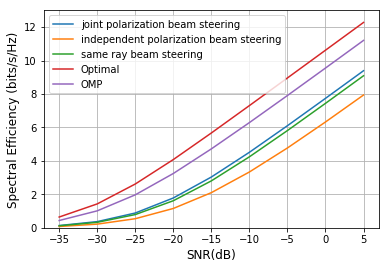

In [32]:
plt.plot(SNR_dB, (np.sum(R_cross,axis=1).real)/realization, label='joint polarization beam steering')
plt.plot(SNR_dB, (np.sum(R_steer,axis=1).real)/realization, label='independent polarization beam steering')
plt.plot(SNR_dB, (np.sum(R_samecl,axis=1).real)/realization, label='same ray beam steering')
plt.plot(SNR_dB, (np.sum(R_o,axis=1).real)/realization, label='Optimal')
plt.plot(SNR_dB, (np.sum(R,axis=1).real)/realization, label='OMP')


plt.legend(loc='upper left',prop={'size': 10})
plt.xlabel('SNR(dB)',fontsize=12)
plt.ylabel('Spectral Efficiency (bits/s/Hz)',fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.ylim(0,13)
plt.grid()
plt.show()